In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
import time
import sys
from sklearn.model_selection import GridSearchCV, KFold
sys.path.append(os.path.join(os.path.abspath('../'), 'predictions_collapsed'))
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
import glob

from config_loader import (
    D_CONFIG,
    DATASET_SITE_PATH, DATASET_SPLIT_PATH,
    DATASET_FEAT_PER_TSLICE_PATH,
    PROJECT_REPO_DIR, PROJECT_CONDA_ENV_YAML,
    RESULTS_SPLIT_PATH, RESULTS_FEAT_PER_TSTEP_PATH)

sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src'))
from feature_transformation import *


%matplotlib inline

<ipython-input-2-a8a8fc73b38a>:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [7]:
# get the train test validation labels
y_train_df = pd.read_csv('/home/prash/datasets/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/classifier_train_test_split/y_train.csv.gz', 
                         nrows=200000)
y_dict = json.load(open(('/home/prash/datasets/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/classifier_train_test_split/y_dict.json')))
# y_valid_df = pd.read_csv('/home/prash/datasets/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/classifier_train_test_split/y_valid.csv.gz')
# y_test_df = pd.read_csv('/home/prash/datasets/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/classifier_train_test_split/y_test.csv.gz')

x_train_df = pd.read_csv('/home/prash/datasets/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/classifier_train_test_split/x_train.csv.gz', 
                         nrows=200000)
x_dict = json.load(open(('/home/prash/datasets/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/classifier_train_test_split/x_dict.json')))

# x_valid_df = pd.read_csv('/home/prash/datasets/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/classifier_train_test_split/x_valid.csv.gz')
# x_test_df = pd.read_csv('/home/prash/datasets/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/classifier_train_test_split/x_test.csv.gz')

In [4]:
def lasso_regression_multi_train_test_splits(
        X_train, y_train, n_trials, n_cv_folds,
        gridsearchvalues__alpha=np.logspace(-5, 5, 5),
        x_feature_transform='none',
        scoring_metric='mean_squared_error'):
    """ Perform nested cross-validation to train Lasso predictor given a fixed training set
    Returns
    -------
    best_regressor_per_trial : list
    perf_dict_per_trial : list
    """
    start_time_sec = time.time()

    print("Fitting Lasso with %d trials of %d-fold nested cross validation" % (
        n_trials, n_cv_folds))

    # Parameter grid to consider on each inner heldout fold
    if isinstance(gridsearchvalues__alpha, str):
        if gridsearchvalues__alpha.count("logspace"):
            gsv = gridsearchvalues__alpha.replace("logspace", "")
            gsv = gsv.replace("(", "")
            gsv = gsv.replace(")", "")
            amin, amax, anum = map(float, gsv.split(','))
            anum = int(anum)
            alpha_grid = np.logspace(amin, amax, anum).astype(np.float64)
        elif gridsearchvalues__alpha.count("linspace"):
            gsv = gridsearchvalues__alpha.replace("linspace", "")
            gsv = gsv.replace("(", "")
            gsv = gsv.replace(")", "")
            amin, amax, anum = map(float, gsv.split(','))
            anum = int(anum)
            alpha_grid = np.linspace(amin, amax, anum).astype(np.float64)
        else:
            alpha_grid = np.asarray(
                list(map(float, gridsearchvalues__alpha.split(","))),
                dtype=np.float64)
    else:
        alpha_grid = np.asarray(gridsearchvalues__alpha, dtype=np.float64)
    alpha_str = ','.join(['%.3g' % a for a in alpha_grid[:3]])
    if alpha_grid.size > 5:
        alpha_str += ',' + '...'
    if alpha_grid.size > 3:
        M = np.maximum(3, alpha_grid.size - 2)
        alpha_str += ',' + ','.join(['%.3g' % a for a in alpha_grid[M:]])
    print("Selecting parameter 'alpha' based on grid search over %d param values:\n%s" % (
        alpha_grid.size, alpha_str))
    param_grid = [{'regressor__alpha': alpha_grid}]
    
    # Arrays to store scores
    best_regressors = [None for _ in range(n_trials)]
    outer_perf_dict_list = [None for _ in range(n_trials)]
    inner_perf_df_list = [None for _ in range(n_trials)]

    # Loop for each trial
    for i in range(n_trials):
      
        # Perform OUTER train-test split
        # If we use a test size of 1/(K+1)
        # Then we'll get heldout folds of the same size as the inner heldout folds with K-fold CV
        # Why?
        # Outer fold takes 1/(K+1) of N examples
        # Inner fold takes 1/K of ( K/(K+1) * N ) examples = 1/(K+1) * N
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1.0/(1+n_cv_folds)), random_state=i)  

        # create a cv splitter object 
        inner_cv_splitter = KFold(n_splits=n_cv_folds, shuffle=True, random_state=i)
        
        # STEP 1 in pipeline: 
        step_list = list()
        if x_feature_transform.startswith('standardize'):
            ## Scale the input features to have zero mean/unit variance
            scaler_x = StandardScaler()
            step_list.append(('standardize', scaler_x))
        elif x_feature_transform == 'scale_0_to_1':
            ## Scale the input features to have min zero and max one
            scaler_x = MaxAbsScaler()
            step_list.append(('scale_0_to_1', scaler_x))
        elif x_feature_transform == 'none':
            pass
        else:
            raise ValueError("Unrecognized value: 'x_feature_transform'=%s" % x_feature_transform)
        
        # STEP 2 in pipeline: Define the predictor from input to output
        step_list.append(('regressor', Lasso(max_iter=1000000, tol=0.001, selection='cyclic')))

        ## Create Pipeline regressor as composition of steps
        prediction_pipeline = Pipeline(step_list)

        ## Prepare for n-fold cross validation
        if scoring_metric == 'mean_absolute_error':
            scoring = 'neg_mean_absolute_error'
            baseline_func = np.median
        elif scoring_metric == 'mean_squared_error':
            scoring = 'neg_mean_squared_error'
            baseline_func = np.mean
        else:
            raise ValueError("Unrecognized value: 'scoring_metric'=%s" % scoring_metric)

        regressor_with_grid_search = GridSearchCV(
                prediction_pipeline, param_grid,
                cv=inner_cv_splitter,
                scoring=scoring,
                return_train_score=True,
                iid=False,
                refit=True)
        regressor_with_grid_search.fit(X_train, y_train)

        best_i = regressor_with_grid_search.best_index_
        inner_cv_df = pd.DataFrame(regressor_with_grid_search.cv_results_)
        perf_at_best_df = inner_cv_df.iloc[best_i:(best_i+1)].copy()

        best_regressors[i] = regressor_with_grid_search.best_estimator_
        outer_train_score = regressor_with_grid_search.score(X_train, y_train)
        outer_test_score = regressor_with_grid_search.score(X_test, y_test)
        cur_perf = OrderedDict()
        cur_perf['trial_id'] = i
        for mname, metric_func in [
                ('mse', mean_squared_error),
                ('mae', mean_absolute_error)
                ]:
            yhat_train = best_regressors[i].predict(X_train)
            yhat_test = best_regressors[i].predict(X_test)
            cur_perf['train_%s' % mname] = metric_func(y_train, yhat_train)
            cur_perf['test_%s' % mname] = metric_func(y_test, yhat_test)
        cur_perf['train_size'] = y_train.size
        cur_perf['test_size'] = y_test.size

        cur_perf['outer_train_score'] = -1 * outer_train_score
        cur_perf['outer_test_score'] = -1 * outer_test_score
        cur_perf['inner_mean_train_score'] = -1 * perf_at_best_df['mean_train_score'].values[0]
        cur_perf['inner_mean_test_score'] = -1 * perf_at_best_df['mean_test_score'].values[0]
        tr_vals = np.zeros(n_cv_folds)
        te_vals = np.zeros(n_cv_folds)
        for ss in range(n_cv_folds):
            key = 'split%d' % ss
            tr_vals[ss] = -1 * perf_at_best_df['%s_train_score' % key].values[0]
            te_vals[ss] = -1 * perf_at_best_df['%s_test_score' % key].values[0]
            cur_perf['inner_%s_train_score' % key] = tr_vals[ss]
            cur_perf['inner_%s_test_score' % key] = te_vals[ss]
        for fname, func in [('min', np.min), ('max', np.max)]:
            cur_perf['inner_%s_train_score' % fname] = func(tr_vals)
            cur_perf['inner_%s_test_score' % fname] = func(te_vals)
        outer_perf_dict_list[i] = cur_perf

        cur_perf['outer_model_bias'] = best_regressors[i]['regressor'].intercept_
        cur_perf['outer_model_num_nonzero_coef'] = np.sum(np.abs(best_regressors[i]['regressor'].coef_) > 1e-8)

        for key in sorted(regressor_with_grid_search.best_params_.keys()):
            cur_perf['outer_model_best_param__%s' % key] = regressor_with_grid_search.best_params_[key]

        outer_perf_dict_list[i] = cur_perf
        inner_perf_df_list[i] = inner_cv_df

        print("completed trial %3d/%d after %8.0f sec | tr score %8.3f | te score %8.3f | nnz %6d" % (
            i + 1, n_trials, time.time() - start_time_sec, 
            cur_perf['outer_train_score'],
            cur_perf['outer_test_score'],
            cur_perf['outer_model_num_nonzero_coef'],
            ))

    outer_perf_df = pd.DataFrame(outer_perf_dict_list)
    return best_regressors, outer_perf_df, inner_perf_df_list


In [8]:
# best_regressors, outer_perf_df, inner_perf_df_list= lasso_regression_multi_train_test_splits(x_train_df.iloc[:, 5:].values.astype(np.float32), 
#                                                                                              y_train_df['clinical_deterioration_outcome'].values, 
#                                                                                              n_trials=1, n_cv_folds=2,
#                                                                                              gridsearchvalues__alpha=np.logspace(-5, 5, 5),
#                                                                                              x_feature_transform='standardize',
#                                                                                              scoring_metric='mean_squared_error')
feature_cols = parse_feature_cols(x_dict)
step_list = list()
scaler_x = StandardScaler()
step_list.append(('standardize', scaler_x))
regressor=Lasso(max_iter=100000)
gridsearchvalues__alpha=np.logspace(-5, 3, 5)
alpha_grid = np.asarray(gridsearchvalues__alpha, dtype=np.float64)
step_list.append(('regressor', regressor))
param_grid = [{'regressor__alpha': alpha_grid}]

scoring = 'neg_mean_absolute_error'


prediction_pipeline = Pipeline(step_list)
regressor_with_grid_search = GridSearchCV(
        prediction_pipeline, param_grid,
        scoring=scoring,
        return_train_score=True,
        iid=False,
        refit=True, cv=2, verbose=10)
regressor_with_grid_search.fit(x_train_df[feature_cols].values.astype(np.float32), 
                               y_train_df['clinical_deterioration_outcome'].values)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] regressor__alpha=0.001 ..........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  regressor__alpha=0.001, score=(train=-0.009, test=-0.071), total=  13.0s
[CV] regressor__alpha=0.001 ..........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s remaining:    0.0s


[CV]  regressor__alpha=0.001, score=(train=-0.009, test=-0.044), total=  21.2s
[CV] regressor__alpha=0.03162277660168379 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.6s remaining:    0.0s


[CV]  regressor__alpha=0.03162277660168379, score=(train=-0.009, test=-0.009), total=   8.9s
[CV] regressor__alpha=0.03162277660168379 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   48.1s remaining:    0.0s


[CV]  regressor__alpha=0.03162277660168379, score=(train=-0.009, test=-0.009), total=   8.9s
[CV] regressor__alpha=1.0 ............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   58.6s remaining:    0.0s


[CV]  regressor__alpha=1.0, score=(train=-0.009, test=-0.009), total=   8.8s
[CV] regressor__alpha=1.0 ............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s


[CV]  regressor__alpha=1.0, score=(train=-0.009, test=-0.009), total=   8.9s
[CV] regressor__alpha=31.622776601683793 .............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV]  regressor__alpha=31.622776601683793, score=(train=-0.009, test=-0.009), total=   8.8s
[CV] regressor__alpha=31.622776601683793 .............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.5min remaining:    0.0s


[CV]  regressor__alpha=31.622776601683793, score=(train=-0.009, test=-0.009), total=   8.8s
[CV] regressor__alpha=1000.0 .........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.7min remaining:    0.0s


[CV]  regressor__alpha=1000.0, score=(train=-0.009, test=-0.009), total=   8.8s
[CV] regressor__alpha=1000.0 .........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.9min remaining:    0.0s


[CV]  regressor__alpha=1000.0, score=(train=-0.009, test=-0.009), total=   8.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.0min finished
/home/prash/.conda/envs/madrid_data_prep/lib/python3.8/site-packages/sklearn/model_selection/_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardize',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('regressor',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True,
                                              max_iter=100000, normalize=False,
                                              positive=False, precompute=False,
                                              random_state=None,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid=False, n_jobs=None,
           

In [11]:
regressor_with_grid_search.best_estimator_['regressor']

Lasso(alpha=0.03162277660168379, copy_X=True, fit_intercept=True,
      max_iter=100000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Text(0, 0.5, 'HR')

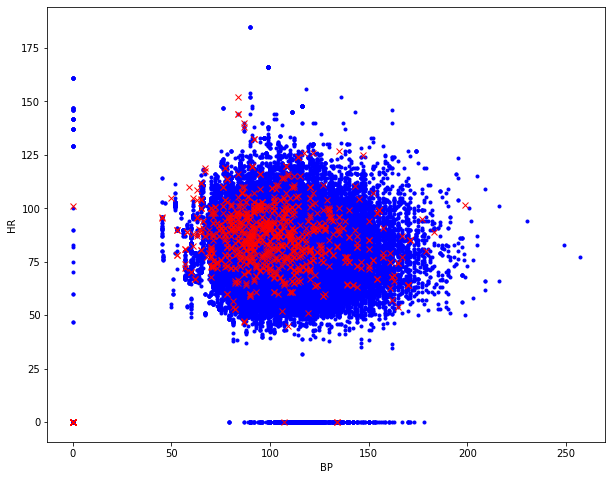

In [24]:
f, axs = plt.subplots(1, 1, figsize=(10, 8))

x = x_train_df['systolic_blood_pressure_min_0-100']
y = x_train_df['heart_rate_median_0-100']
outcomes = y_train_df['clinical_deterioration_outcome'].values


axs.plot(x[outcomes==0], y[outcomes==0], 'b.')
axs.plot(x[outcomes==1], y[outcomes==1], 'rx')
axs.set_xlabel('BP')
axs.set_ylabel('HR')

In [25]:
out_dir = '/home/prash/datasets/'

np.save(os.path.join(out_dir, 'feat_systolic_BP.npy'), x)
np.save(os.path.join(out_dir, 'feat_heart_rate.npy'), y)
np.save(os.path.join(out_dir, 'outcome.npy'), outcomes)